In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers, models, optimizers

In [2]:
os.chdir('C://Users//BIS_COM//data//kaggle//segmentation_full_body_mads_dataset_1192_img/')

In [3]:
IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT = 3, 512, 384

In [4]:
X_ids = next(os.walk('./images'))[2]
y_ids = next(os.walk('./masks'))[2]

In [5]:
X_train = np.zeros((len(X_ids), 256, 256, 3), dtype=np.float32)
y_train = np.zeros((len(y_ids), 256, 256, 1), dtype=np.bool)

for n, id_ in enumerate(X_ids):
    image = tf.keras.preprocessing.image.load_img(f'./images/{id_}', target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[:,:]
    image = tf.keras.preprocessing.image.array_to_img(input_arr, ).resize((256, 256))
    X_train[n] = np.array(image)

for n, id_ in enumerate(y_ids):
    image = tf.keras.preprocessing.image.load_img(f'./masks/{id_}', 
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[:,:]
    image = tf.keras.preprocessing.image.array_to_img(input_arr).resize((256, 256))
    y_train[n] = np.array(image)[:, :, np.newaxis]

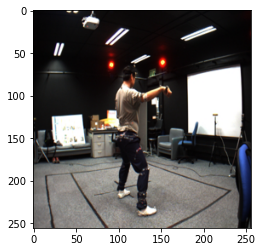

In [6]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(X_train[1000]))

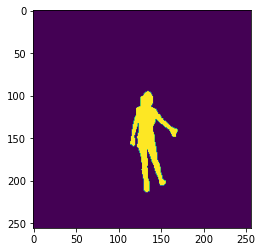

In [7]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(y_train[499]))

In [8]:
X_train, y_train = X_train / 255.0, y_train / 255.0

X_float = X_train.astype("float32")
y_float = y_train.astype("float32")

In [9]:
X_float.shape

(1192, 256, 256, 3)

In [10]:
train_size = int(len(X_float)*0.8)
test_size = int(len(X_float)) - train_size
print(train_size, test_size, train_size+ test_size)

953 239 1192


In [11]:
X_train_float = X_float[:train_size,:,:,:]
X_test_float = X_float[train_size:,:,:,:]
print(X_train_float.shape,X_test_float.shape)

(953, 256, 256, 3) (239, 256, 256, 3)


In [12]:
y_train_float = y_float[:train_size,:,:,:]
y_test_float = y_float[train_size:,:,:,:]
print(y_train_float.shape,y_test_float.shape)

(953, 256, 256, 1) (239, 256, 256, 1)


In [13]:
X_train_float.shape[1:]

(256, 256, 3)

In [15]:
inputs = tf.keras.layers.Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d_8[0][0]                   
_______________________________________________________________________________________

In [17]:
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=25)

Epoch 1/25
67/67 [==============================] - 215s 3s/step - loss: 0.0449 - accuracy: 0.9500 - val_loss: 0.0044 - val_accuracy: 0.9406
Epoch 2/25
67/67 [==============================] - 212s 3s/step - loss: 0.0018 - accuracy: 0.9529 - val_loss: 0.0037 - val_accuracy: 0.9406
Epoch 3/25
67/67 [==============================] - 214s 3s/step - loss: 0.0017 - accuracy: 0.9529 - val_loss: 0.0037 - val_accuracy: 0.9406
Epoch 4/25
67/67 [==============================] - 208s 3s/step - loss: 0.0016 - accuracy: 0.9529 - val_loss: 0.0026 - val_accuracy: 0.9406
Epoch 5/25
67/67 [==============================] - 188s 3s/step - loss: 0.0016 - accuracy: 0.9529 - val_loss: 0.0025 - val_accuracy: 0.9406
Epoch 6/25
67/67 [==============================] - 187s 3s/step - loss: 0.0016 - accuracy: 0.9529 - val_loss: 0.0030 - val_accuracy: 0.9406
Epoch 7/25
67/67 [==============================] - 187s 3s/step - loss: 0.0015 - accuracy: 0.9529 - val_loss: 0.0025 - val_accuracy: 0.9406
Epoch 8/25
67

In [19]:
score = model.evaluate(X_test_float, y_test_float, batch_size = 16, verbose=1)
print("Test Score : {}, Test Acc : {}".format(score[0],score[1]))

15/15 [==============================] - 7s 465ms/step - loss: 0.0018 - accuracy: 0.9385
Test Score : 0.0018161711050197482, Test Acc : 0.9384964108467102


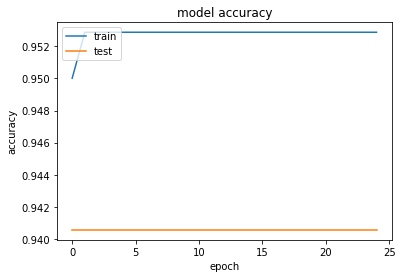

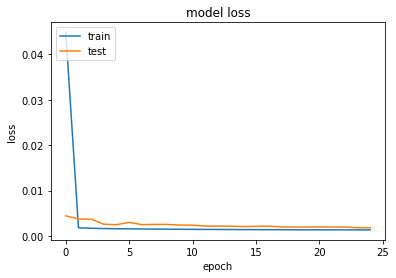

In [20]:
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
import random

test_id = random.choice(X_ids)
print(test_id)

Jazz_Jazz1_C1_00585.png


In [24]:
img = tf.keras.preprocessing.image.load_img(f"./images/{test_id}", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.
predictions = model.predict(input_array)

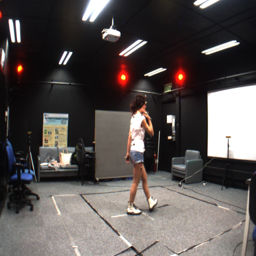

In [25]:
Image.open(f"./images/{test_id}").resize((256, 256))

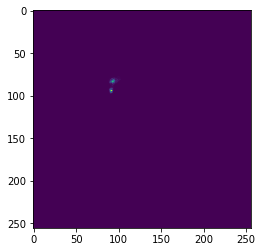

In [26]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(np.squeeze(predictions)[:, :, np.newaxis]))

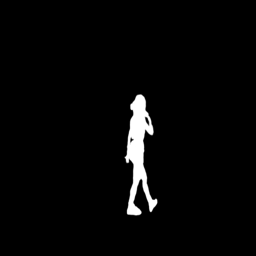

In [28]:
Image.open(f"./masks/{test_id}").resize((256 ,256))